In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.signal import find_peaks
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
def get_signal_generator(batch_size, n_points, mean_distance, std_distance, 
                         mean_width, std_width):
    def generate_one():
        first = np.random.uniform(0, n_points /4)
        second = first + np.random.normal(mean_distance * n_points, std_distance * n_points)
        if second > n_points * 0.95:
            second = n_points * 0.95
        distance = second - first
        first_width = max(np.random.normal(mean_width * n_points, std_width * n_points), n_points * std_width)
        second_width = max(np.random.normal(mean_width * n_points, std_width * n_points), n_points * std_width)
        data_range = np.arange(n_points)
        signal = norm.pdf(data_range, first, first_width) + \
            norm.pdf(data_range, second, second_width)
        return signal, distance
        
    def generate():
        sanity=100000
        for _ in range(sanity):
            all_data = [generate_one() for _ in range(batch_size)]
            yield np.vstack([element[0] for element in all_data]), np.vstack([element[1] for element in all_data])
        
    return generate()

In [3]:
data_generator = get_signal_generator(2, 1000, 0.3, 0.1, 0.03, 0.01)
batch = next(data_generator)

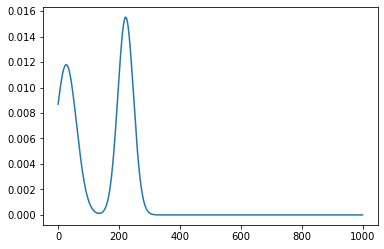

In [4]:
plt.plot(batch[0][0,:]);

## Finding peaks

Now that we have the generator functtion we can  use the standard signal processing library to find the distance between peaks

In [5]:
def predict_distance(batch):
    def compute_distance(row):
        peaks = find_peaks(row)[0]
        if len(peaks) < 2:
            return 0
        return abs(peaks[1] - peaks[0])
                   
    return np.vstack([compute_distance(batch[i,:]) for i in range(batch.shape[0])])
    

Now we evaluate our base model

In [6]:
np.random.seed(2128506)
data_generator = get_signal_generator(500, 1000, 0.7, 0.1, 0.03, 0.01)
batch_x, batch_y = next(data_generator)

In [7]:
predictions = predict_distance(batch_x)
print('Baseline performance: ', r2_score(batch_y, predictions))

Baseline performance:  0.9999812121197582


## Fitting a deep learning model

In [35]:
from tensorflow.keras.layers import Conv1D, Dense, Input, Reshape, Flatten
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, TerminateOnNaN
from tensorflow.keras.optimizers import Adam

In [9]:
model = Sequential([
    Dense(100,input_shape=(1000,), activation='relu'),
    Dense(1)
])

In [13]:
model.compile(optimizer='sgd', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               100100    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 100,201
Trainable params: 100,201
Non-trainable params: 0
_________________________________________________________________


In [11]:
np.random.seed(2128506)
tf.random.seed(2128506)
data_generator = get_signal_generator(500, 1000, 0.7, 0.1, 0.03, 0.01)
model.fit(data_generator, epochs=50, steps_per_epoch=100, callbacks=[EarlyStopping(monitor='loss'), TerminateOnNaN()])

Epoch 1/50
100/100 [==============================] - 12s 121ms/step - loss: 142948.6562
Epoch 2/50
100/100 [==============================] - 13s 133ms/step - loss: 10053.8936
Epoch 3/50
100/100 [==============================] - 14s 140ms/step - loss: 7863.5845
Epoch 4/50
100/100 [==============================] - 14s 138ms/step - loss: 7721.4336
Epoch 5/50
100/100 [==============================] - 14s 138ms/step - loss: 7771.6167


In [28]:
batch_x, batch_y = next(data_generator)
predictions = model.predict(batch_x)
print('R^2 score: ', r2_score(batch_y, predictions))

ValueError: Found array with dim 3. Estimator expected <= 2.

## Using CNN

In [36]:
model = Sequential([
    Input(shape=(1000,)),
    Reshape((-1,1)),      
    Conv1D(filters=1, kernel_size=3, input_shape=(1000,1), activation='relu'),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(1)
])
model.compile(optimizer=Adam(lr=0.7), loss='mse')
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 1000, 1)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 998, 1)            4         
_________________________________________________________________
flatten (Flatten)            (None, 998)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               99900     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 101       
Total params: 100,005
Trainable params: 100,005
Non-trainable params: 0
_________________________________________________________________


In [27]:
np.random.seed(2128506)
tf.random.seed(2128506)
data_generator = get_signal_generator(500, 1000, 0.7, 0.1, 0.03, 0.01)
model.fit(data_generator, epochs=50, steps_per_epoch=100, callbacks=[EarlyStopping(monitor='loss'), TerminateOnNaN()])

Epoch 1/50
100/100 [==============================] - 26s 262ms/step - loss: 438946.1250
Epoch 2/50
100/100 [==============================] - 29s 290ms/step - loss: 355086.8125
Epoch 3/50
100/100 [==============================] - 29s 287ms/step - loss: 283822.6250
Epoch 4/50
100/100 [==============================] - 29s 292ms/step - loss: 225467.0469
Epoch 5/50
100/100 [==============================] - 29s 294ms/step - loss: 176386.3594
Epoch 6/50
100/100 [==============================] - 28s 284ms/step - loss: 136005.8906
Epoch 7/50
100/100 [==============================] - 29s 286ms/step - loss: 104118.2656
Epoch 8/50
100/100 [==============================] - 29s 287ms/step - loss: 78743.3438
Epoch 9/50
100/100 [==============================] - 28s 284ms/step - loss: 58985.4727
Epoch 10/50
100/100 [==============================] - 28s 284ms/step - loss: 44080.6914
Epoch 11/50
100/100 [==============================] - 28s 284ms/step - loss: 32982.3164
Epoch 12/50
100/100 [==

ValueError: generator already executing

In [31]:
batch_x, batch_y = next(data_generator)
predictions = model.predict(batch_x)
print('R^2 score: ', r2_score(batch_y, np.squeeze(predictions)))

ValueError: y_true and y_pred have different number of output (1!=998)

In [33]:
np.squeeze(predictions).shape

(500, 998)

In [34]:
batch_y.shape

(500, 1)